# Module 2 Final Project Submission

* Student name: **Chelsea Power**
* Student pace: **part time**
* Scheduled project review date/time: **May 17, 2019 at 6:30 pm ET**
* Instructor name: **Joe San Pietro**
* Blog post URL: **TBD**

## Question 1: Part I - Do discounts increase customer purchases?

    Ho: Discounts do not have an effect on the number of products ordered.

    Ha: Discounts have an effect on the number of products ordered.

In [1]:
# Import required libraries
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as _stats
from scipy import stats

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Connect an engine and connect to the Northwind database
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=True)

# Create session to execute SQL commands
Session = sessionmaker(bind=engine)
session = Session()
con = engine.connect()

# Extract Order Detail data as a pandas dataframe using a SQL query
df = pd.read_sql_query('''
 SELECT * 
 FROM OrderDetail
 ''', engine)

2019-05-17 13:30:07,739 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-05-17 13:30:07,739 INFO sqlalchemy.engine.base.Engine ()
2019-05-17 13:30:07,741 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-05-17 13:30:07,741 INFO sqlalchemy.engine.base.Engine ()
2019-05-17 13:30:07,743 INFO sqlalchemy.engine.base.Engine 
 SELECT * 
 FROM OrderDetail
 
2019-05-17 13:30:07,744 INFO sqlalchemy.engine.base.Engine ()


In [2]:
# Display OrderDetail as a panda dataframe
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


### Split the data into two separate groups to test the difference.

In [3]:
# Create control group: customers who did not receive a discount
control = df[df['Discount'] == 0]
control = control['Quantity']

# Create experimental group: customers who received a discount
experimental = df[df['Discount'] != 0]
experimental = experimental['Quantity']

In [4]:
# Calculate the difference between distribution means
control.mean()
experimental.mean()
experimental.mean() - control.mean()

5.394523243866239

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


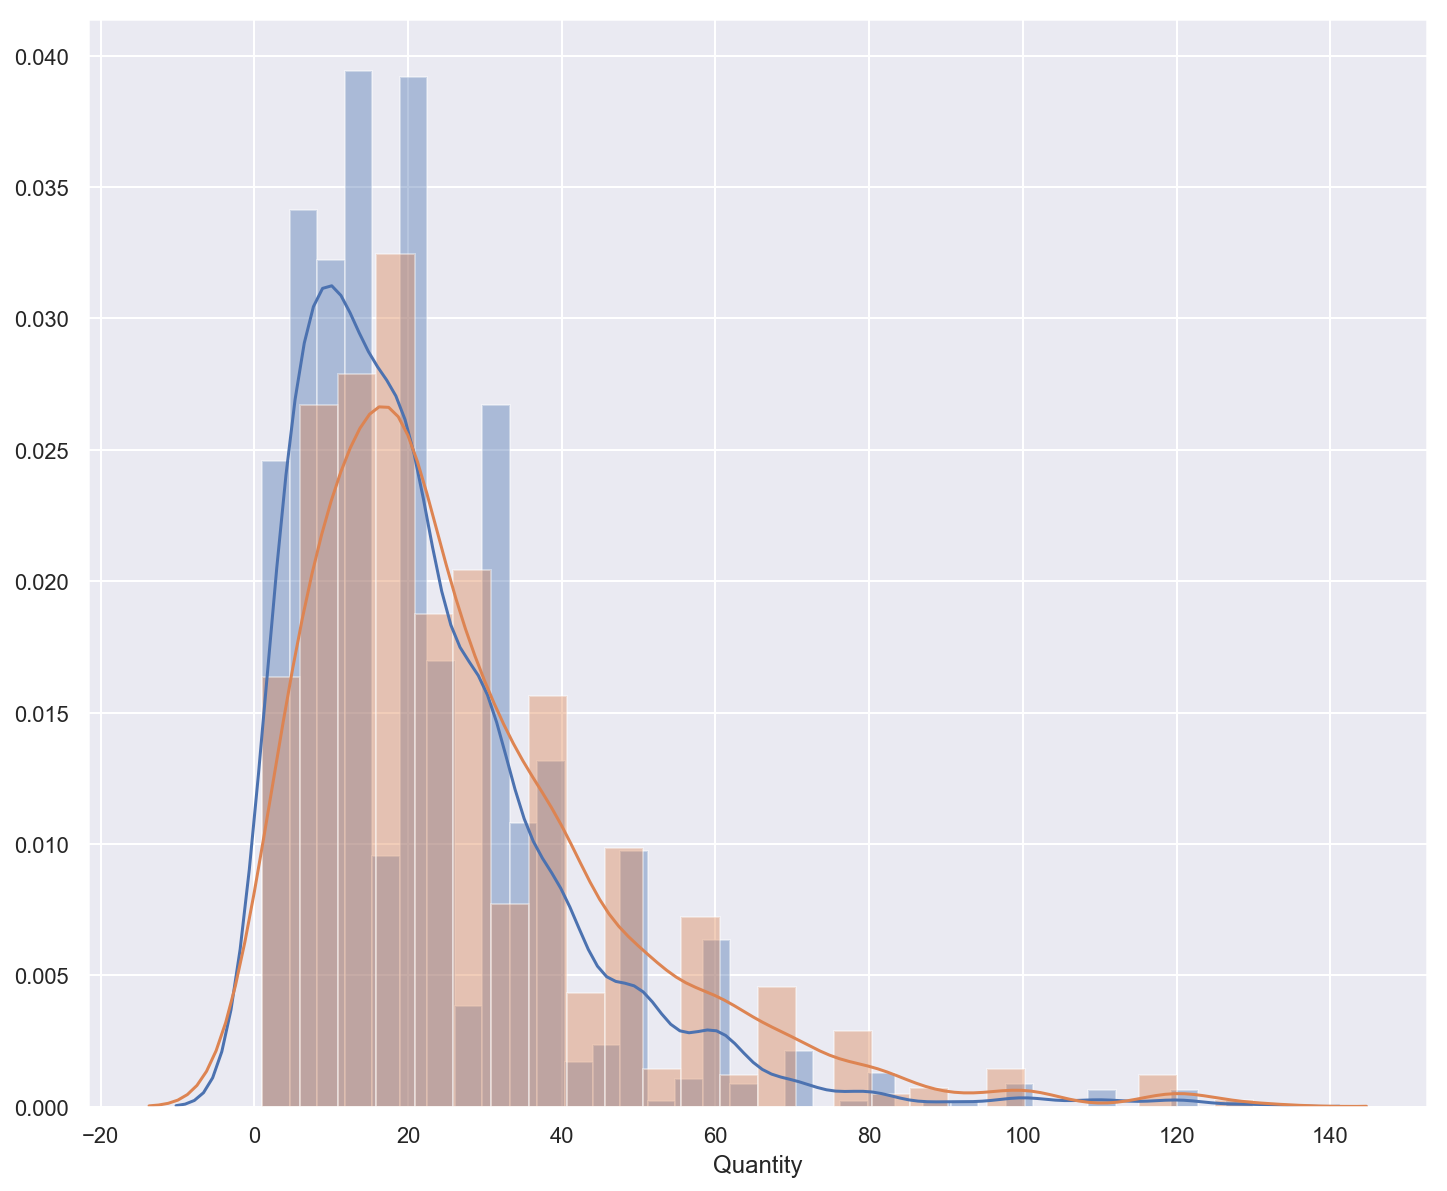

In [5]:
# Plot data and run normality test
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(control) # Blue distribution
sns.distplot(experimental) # Orange distribution

### Create a sample distribution of the sample mean to continue the hypothesis testing

In [6]:
# Create function to sample with replacement
def get_sample(df, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(df)
        sample.append(x)
    return sample

# Create function to calculate mean of the sample
def get_sample_mean(sample):
    return sum(sample)/len(sample)

# Combine functions to create a sample distribution
# Create a distribution size of 1000 and sample size of 500
def create_sample_distribution(df, dist_size=1000, n=500):
    sample_dist = [] 
    while len(sample_dist) != dist_size:
        sample = get_sample(df, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
    return sample_dist

# Create sample distributions of sample mean for control and target
control_sample = create_sample_distribution(control)
exp_sample = create_sample_distribution(experimental)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


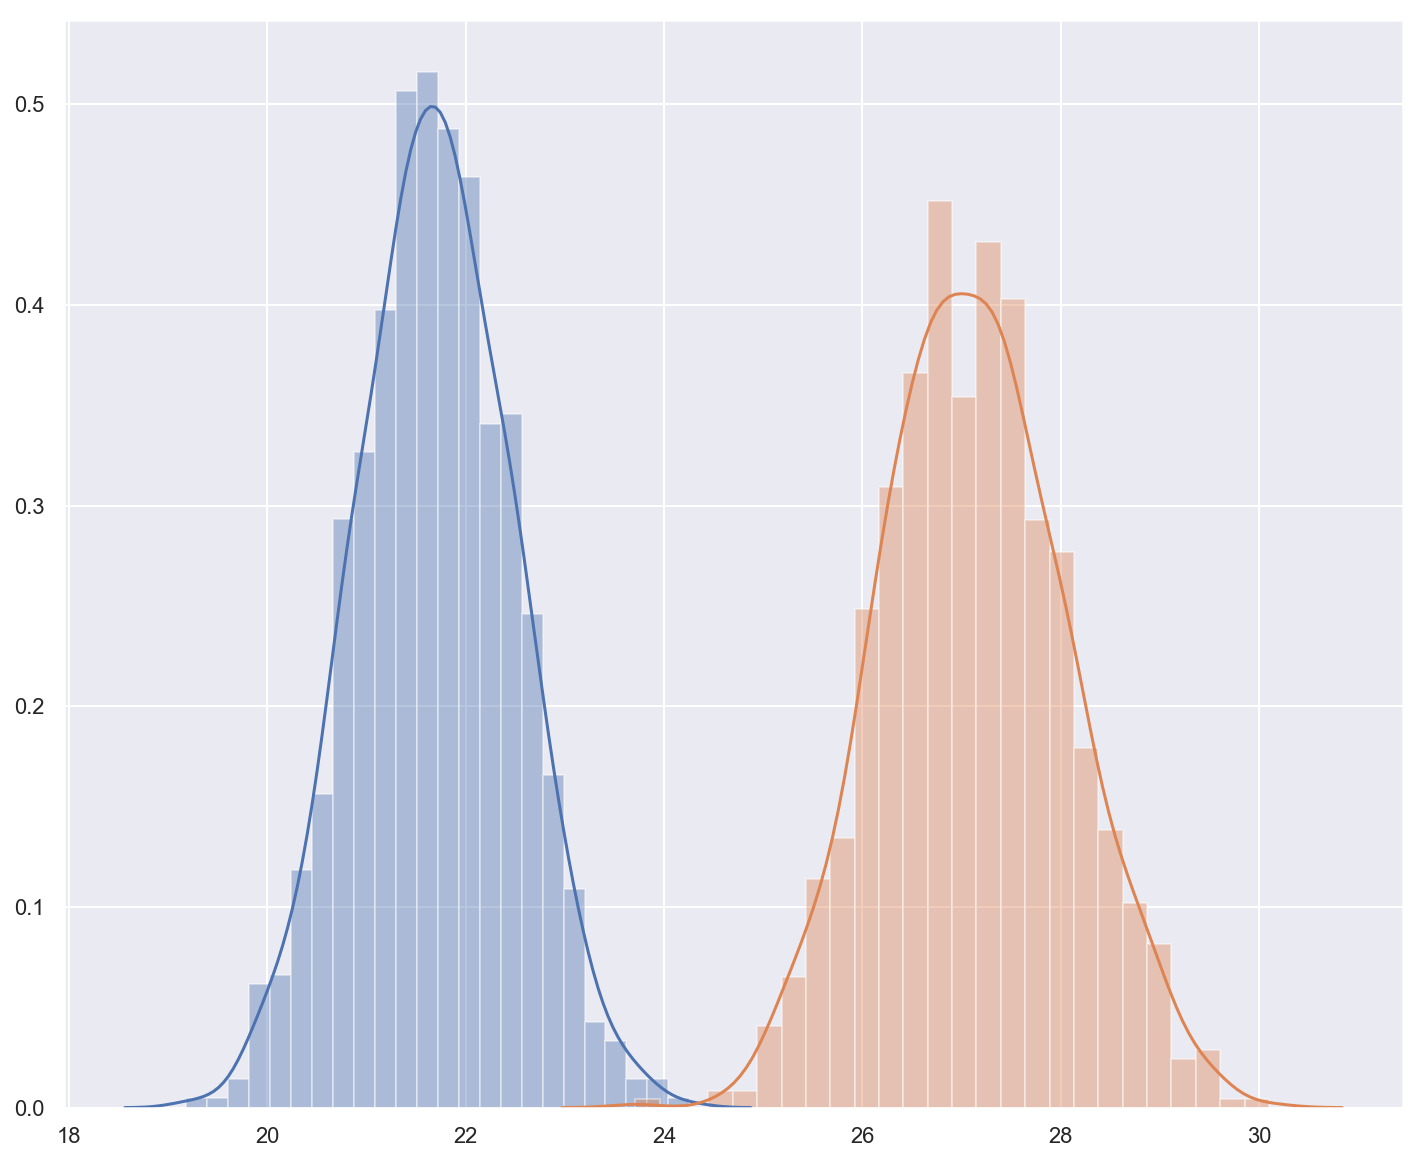

In [7]:
# Plot sample Distribution
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(control_sample) # Blue distribution
sns.distplot(exp_sample) # Orange distribution

In [8]:
# Test whether variances are equal
np.var(control) == np.var(experimental)

False

There is a 21% probability we would see t equal to or greater than what we saw from our data. We can also reject the null hypothesis since p is less than 0.05.

### Effect Size

Measure the magnitude of the difference using **Cohen’s d** where values of 0 - 0.2 have little or no effect and values > 0.8 have a large effect size.

    d = effect size (difference of means) / pooled standard deviation

In [9]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [10]:
print("Cohen's d:", Cohen_d(np.array(exp_sample), np.array(control_sample)))

Cohen's d: 6.342291292124524


Based on **Cohen's d**, the discount amount has a statistically significant effect on quantity of products ordered.

In [11]:
# Extract Order Detail data as a pandas dataframe using a SQL query
df = pd.read_sql_query('''
 SELECT * 
 FROM OrderDetail
 ''', engine)

2019-05-17 13:30:15,447 INFO sqlalchemy.engine.base.Engine 
 SELECT * 
 FROM OrderDetail
 
2019-05-17 13:30:15,448 INFO sqlalchemy.engine.base.Engine ()


### Perform a one-way ANOVA tests for significant differences between multiple groups. 

Formula:

```Control_Column ~ C(factor_col1) + factor_col2 + C(factor_col3) + ... + X```

In [12]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

discount = df.Discount
quantity = df.Quantity

formula = 'quantity ~ C(discount)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq      df         F        PR(>F)
C(discount)   21258.403604    10.0  6.011811  4.704231e-09
Residual     758141.232591  2144.0       NaN           NaN


The result **p (4.7e-09) < α**, so we reject the null hypothesis. 

## Question 1: Part II - What discount levels have an effect on the quantity of products ordered? (Does a 5% discount have the same effect as a 20% discount?)

Perform multiple comparison analysis to look at all possible pair means to determine if **discount amounts of 5, 15, 20 and 25%** produce a statistically significant effect on the mean quantity of product ordered.

In [13]:
#Tukey's range test - compares all possible pairs and we can use it to precisely 
#identify difference between two means that's greater than the expected standard error.
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(df['Quantity'], df['Discount'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
 0.0    0.01  -19.7153 -80.3306 40.9001 False 
 0.0    0.02  -19.7153 -62.593  23.1625 False 
 0.0    0.03  -20.0486 -55.0714 14.9742 False 
 0.0    0.04  -20.7153 -81.3306 39.9001 False 
 0.0    0.05   6.2955   1.5381   11.053  True 
 0.0    0.06  -19.7153 -80.3306 40.9001 False 
 0.0    0.1    3.5217  -1.3783   8.4217 False 
 0.0    0.15   6.6669   1.551   11.7828  True 
 0.0    0.2    5.3096   0.2508  10.3684  True 
 0.0    0.25   6.525    1.3647  11.6852  True 
 0.01   0.02    0.0    -74.2101 74.2101 False 
 0.01   0.03  -0.3333  -70.2993 69.6326 False 
 0.01   0.04    -1.0   -86.6905 84.6905 False 
 0.01   0.05  26.0108  -34.745  86.7667 False 
 0.01   0.06    0.0    -85.6905 85.6905 False 
 0.01   0.1    23.237  -37.5302 84.0042 False 
 0.01   0.15  26.3822  -34.4028 87.1671 False 
 0.01   0.2   25.0248  -35.7554  85.805 False 
 0.01   0

Results of **’reject = True’** means that a significant difference has been observed.

## Question 2: Does the revenue per order vary by different regions?

    Ho: Revenue per order does not vary by region.
    
    Ha: Revenue per order varies by different regions.

In [14]:
# Extract data required as a pandas dataframe using a SQL query
df2 = pd.read_sql_query('''
 SELECT Region, Quantity, OrderID, UnitPrice, Discount
 FROM Customer
 LEFT JOIN "Order" ON Customer.Id
 LEFT JOIN OrderDetail ON OrderID
 ''', engine)

2019-05-17 13:31:16,552 INFO sqlalchemy.engine.base.Engine 
 SELECT Region, Quantity, OrderID, UnitPrice, Discount
 FROM Customer
 LEFT JOIN "Order" ON Customer.Id
 LEFT JOIN OrderDetail ON OrderID
 
2019-05-17 13:31:16,553 INFO sqlalchemy.engine.base.Engine ()


In [15]:
# Display dataframe
df2.head()

,Region,Quantity,OrderId,UnitPrice,Discount
0,Western Europe,12,10248,14.0,0.0
1,Western Europe,10,10248,9.8,0.0
2,Western Europe,5,10248,34.8,0.0
3,Western Europe,9,10249,18.6,0.0
4,Western Europe,40,10249,42.4,0.0


In [16]:
# Calculate the revenue per order
df2['Price_Per_Order'] = df2.Quantity * df2.UnitPrice * (1 - df2.Discount)

# Display dataframe
df2.head()

,Region,Quantity,OrderId,UnitPrice,Discount,Price_Per_Order
0,Western Europe,12,10248,14.0,0.0,168.0
1,Western Europe,10,10248,9.8,0.0,98.0
2,Western Europe,5,10248,34.8,0.0,174.0
3,Western Europe,9,10249,18.6,0.0,167.4
4,Western Europe,40,10249,42.4,0.0,1696.0


In [17]:
# Group data by order and add the revenue for each order
df2 = df2.groupby(['Region', 'OrderId'])['Price_Per_Order'].sum().reset_index()

# Drop OrderID since we no longer need this
df2.drop('OrderId', axis=1, inplace=True)

# Combine Eastern and Southern Europe
df2.loc[(df2.Region == 'Eastern Europe') | (df2.Region == 'Southern Europe'),'Region'] = 'Southern and Eastern Europe'

# Combine Scandinavia and Northern Europe
df2.loc[(df2.Region == 'Scandinavia') | (df2.Region == 'Northern Europe'),'Region'] = 'Northern Europe and Scandinavia'

# Combine Central and South America
df2.loc[(df2.Region == 'Central America') | (df2.Region == 'South America'),'Region'] = 'South and Central America'

In [18]:
# Group dataframe by region and show count - confirm region combination
df2.groupby('Region').count()

,Price_Per_Order
Region,
British Isles,830
North America,830
Northern Europe and Scandinavia,1660
South and Central America,1660
Southern and Eastern Europe,1660
Western Europe,830


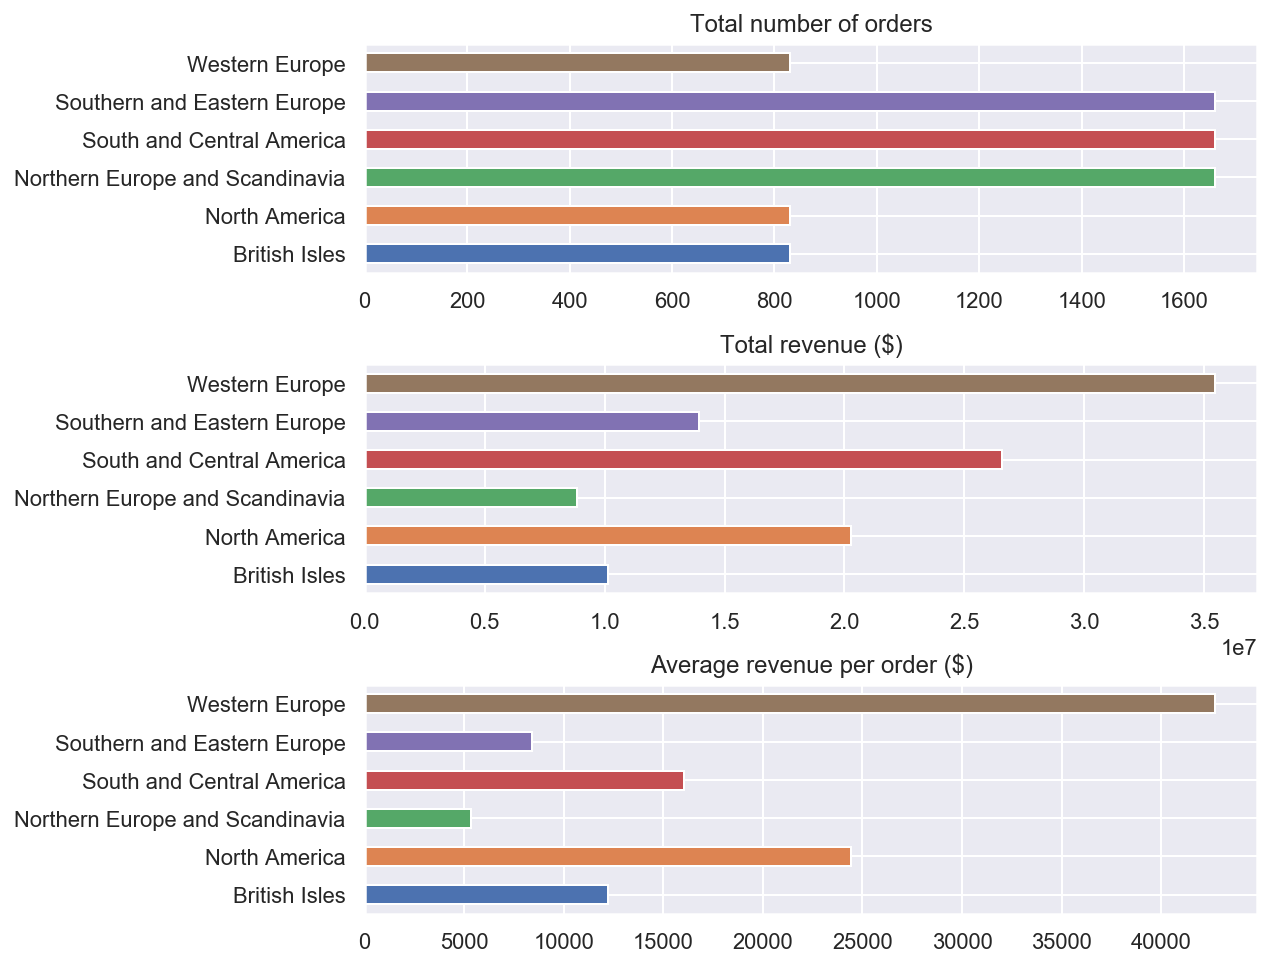

In [19]:
# Plot the number of orders, total revenue per order and average revenue per order for each region
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,8))
df2.groupby(['Region'])['Region'].count().plot(kind='barh', ax=ax1)
df2.groupby(['Region'])['Price_Per_Order'].sum().plot(kind='barh', ax=ax2)
df2.groupby(['Region'])['Price_Per_Order'].mean().plot(kind='barh', ax=ax3)
ax1.set_title('Total number of orders')
ax1.set_ylabel('')
ax2.set_title('Total revenue ($)')
ax2.set_ylabel('')
ax3.set_title('Average revenue per order ($)')
ax3.set_ylabel('')
fig.subplots_adjust(hspace=0.4);

In [20]:
# Create control group: Price per order in North America
control = df2[df2['Region'] == 'North America']
control = control['Price_Per_Order']

# Create experimental group: Price per order everywhere else
experimental = df2[df2['Region'] != 'North America']
experimental = experimental['Price_Per_Order']

In [21]:
# Calculate the difference between distribution means
control.mean()
experimental.mean()
experimental.mean() - control.mean()

-10103.46853817771

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


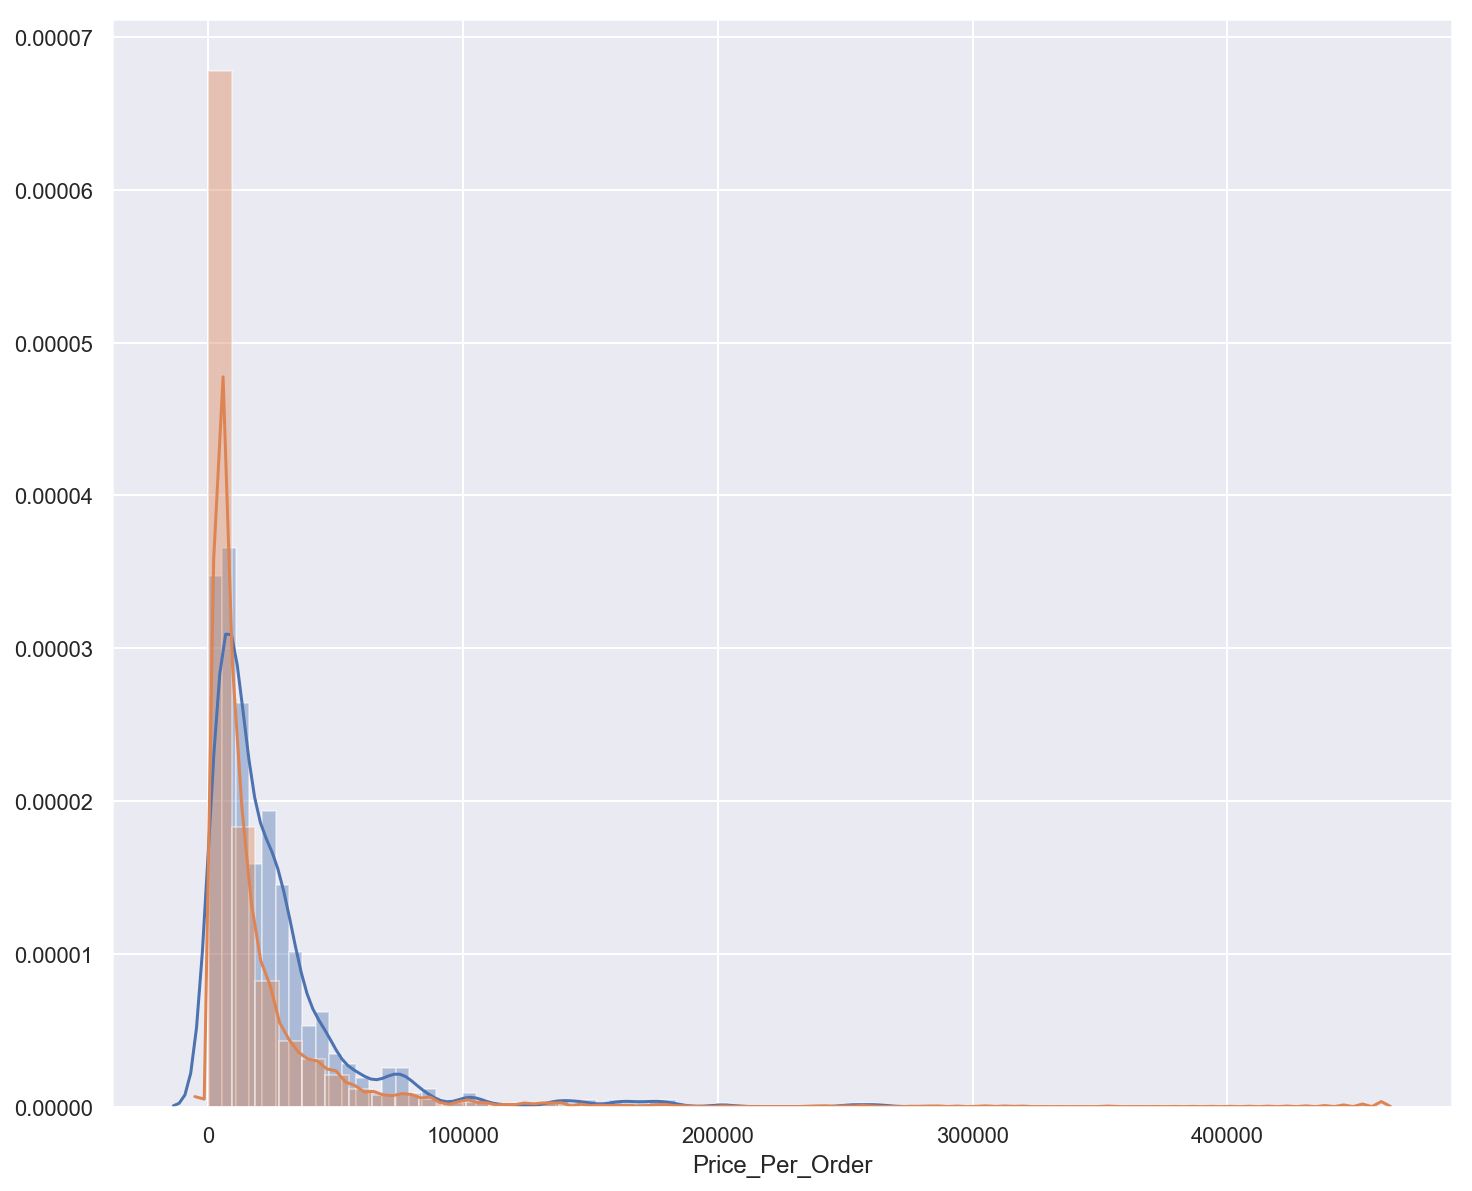

In [22]:
# Plot data and run normality test
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(control) # Blue distribution
sns.distplot(experimental) # Orange distribution

In [23]:
# Create function to sample with replacement
def get_sample(df, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(df)
        sample.append(x)
    return sample

# Create function to calculate mean of the sample
def get_sample_mean(sample):
    return sum(sample)/len(sample)

# Combine functions to create a sample distribution
# Create a distribution size of 1000 and sample size of 500
def create_sample_distribution(df, dist_size=1000, n=500):
    sample_dist = [] 
    while len(sample_dist) != dist_size:
        sample = get_sample(df, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
    return sample_dist

# Create sample distributions of sample mean for control and target
control_sample = create_sample_distribution(control)
exp_sample = create_sample_distribution(experimental)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


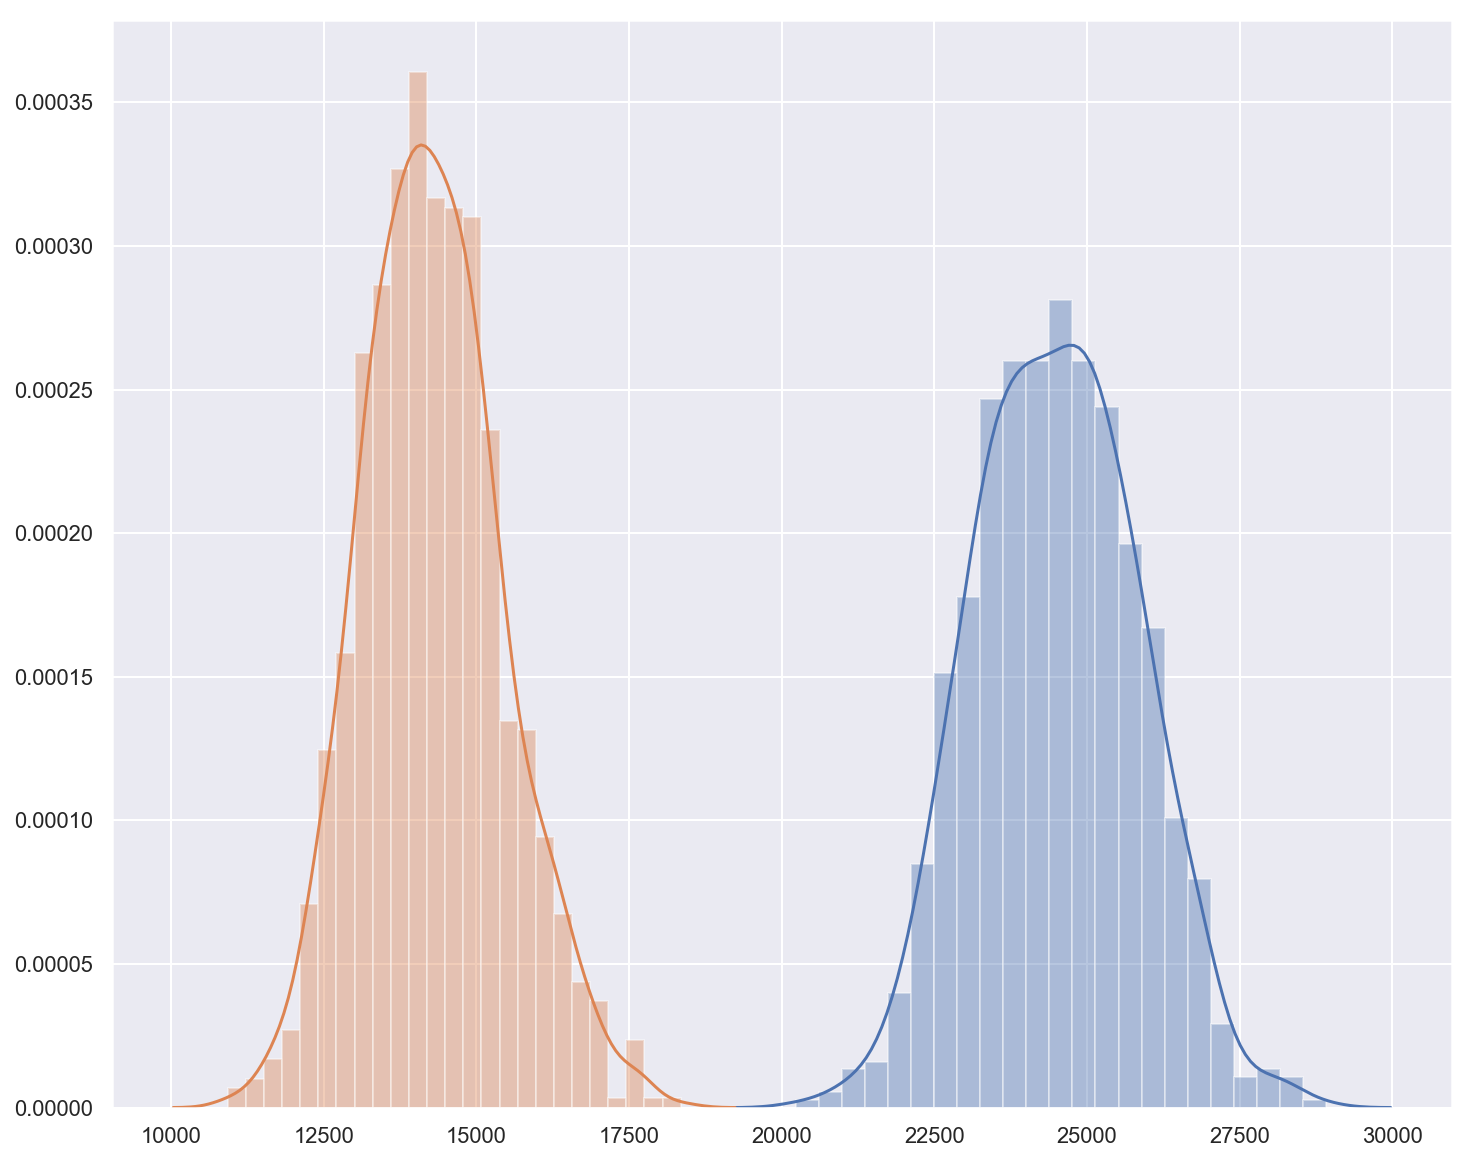

In [24]:
# Plot sample Distribution
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(control_sample) # Blue distribution
sns.distplot(exp_sample) # Orange distribution

In [25]:
# Test whether variances are equal
np.var(control) == np.var(experimental)

False

### Perform a one-way ANOVA test

In [26]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

Region = df2.Region
Price_Per_Order = df2.Price_Per_Order

formula = 'Price_Per_Order ~ C(Region)'
lm = ols(formula, df2).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                 sum_sq      df           F         PR(>F)
C(Region)  9.447163e+11     5.0  316.154448  5.664702e-308
Residual   4.460708e+12  7464.0         NaN            NaN


The result **p (5.6e-308) < α**, so we reject the null hypothesis.

## Question 3: Does the supply region (North America vs others) have an effect on the amount of Chai sold?

    Ho: There is no difference in the quantity of Chai sold between North America and others.

    Ha: There is a regional difference in quantity of Chai sold from North America.

In [28]:
# Extract Order Detail data as a pandas dataframe using a SQL query
df3 = pd.read_sql_query('''
 SELECT Region, ProductName, Quantity, OrderID
 FROM Supplier
 JOIN Product
 ON SupplierID
 LEFT JOIN OrderDetail
 On OrderID
 ''', engine)

2019-05-17 13:34:39,722 INFO sqlalchemy.engine.base.Engine 
 SELECT Region, ProductName, Quantity, OrderID
 FROM Supplier
 JOIN Product
 ON SupplierID
 LEFT JOIN OrderDetail
 On OrderID
 
2019-05-17 13:34:39,723 INFO sqlalchemy.engine.base.Engine ()


In [29]:
# Display Supplier as a panda dataframe
df3.head()

,Region,ProductName,Quantity,OrderId
0,British Isles,Chai,12,10248
1,British Isles,Chai,10,10248
2,British Isles,Chai,5,10248
3,British Isles,Chai,9,10249
4,British Isles,Chai,40,10249


In [30]:
# Drop non-Chai products
df3.drop(df3[ df3['ProductName'] != 'Chai' ].index, inplace=True)

# Combine Northern, Eastern, Southern Europe, Scandinavia and British Isles
df3.loc[(df3.Region == 'Europe') | (df3.Region == 'Southern Europe') | (df3.Region == 'Scandinavia') | (df3.Region == 'British Isles') | (df3.Region == 'Western Europe') | (df3.Region == 'Northern Europe'),'Region'] = 'Europe'

# Confirm the only products are Chai
df3['ProductName'].unique()

array(['Chai'], dtype=object)

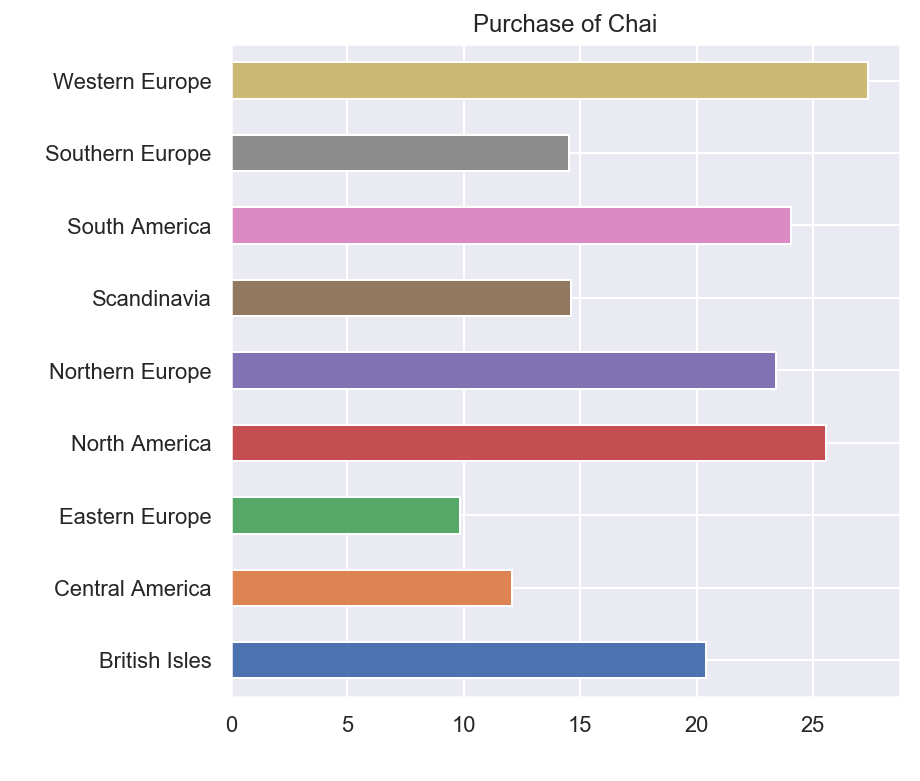

In [58]:
# Plot the number of orders, total revenue per order and average revenue per order for each region
fig, (ax1) = plt.subplots(1, 1, figsize=(6,6))
df4.groupby(['Region'])['Quantity'].mean().plot(kind='barh', ax=ax1)
ax1.set_title('Purchase of Chai by Supply Region')
ax1.set_ylabel(' ')
ax1.set_xlabel(' ')
fig.subplots_adjust(hspace=0.1);

In [31]:
# Create control group: Purchase of Chai in North America
control = df3[df3['Region'] == 'North America']
control = control['Quantity']

# Create experimental group: Purchase of Chai in North America
experimental = df3[df3['Region'] == 'Europe']
experimental = experimental['Quantity']

In [32]:
# Calculate the difference between distribution means
control.mean()
experimental.mean()
experimental.mean() - control.mean()

0.0

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


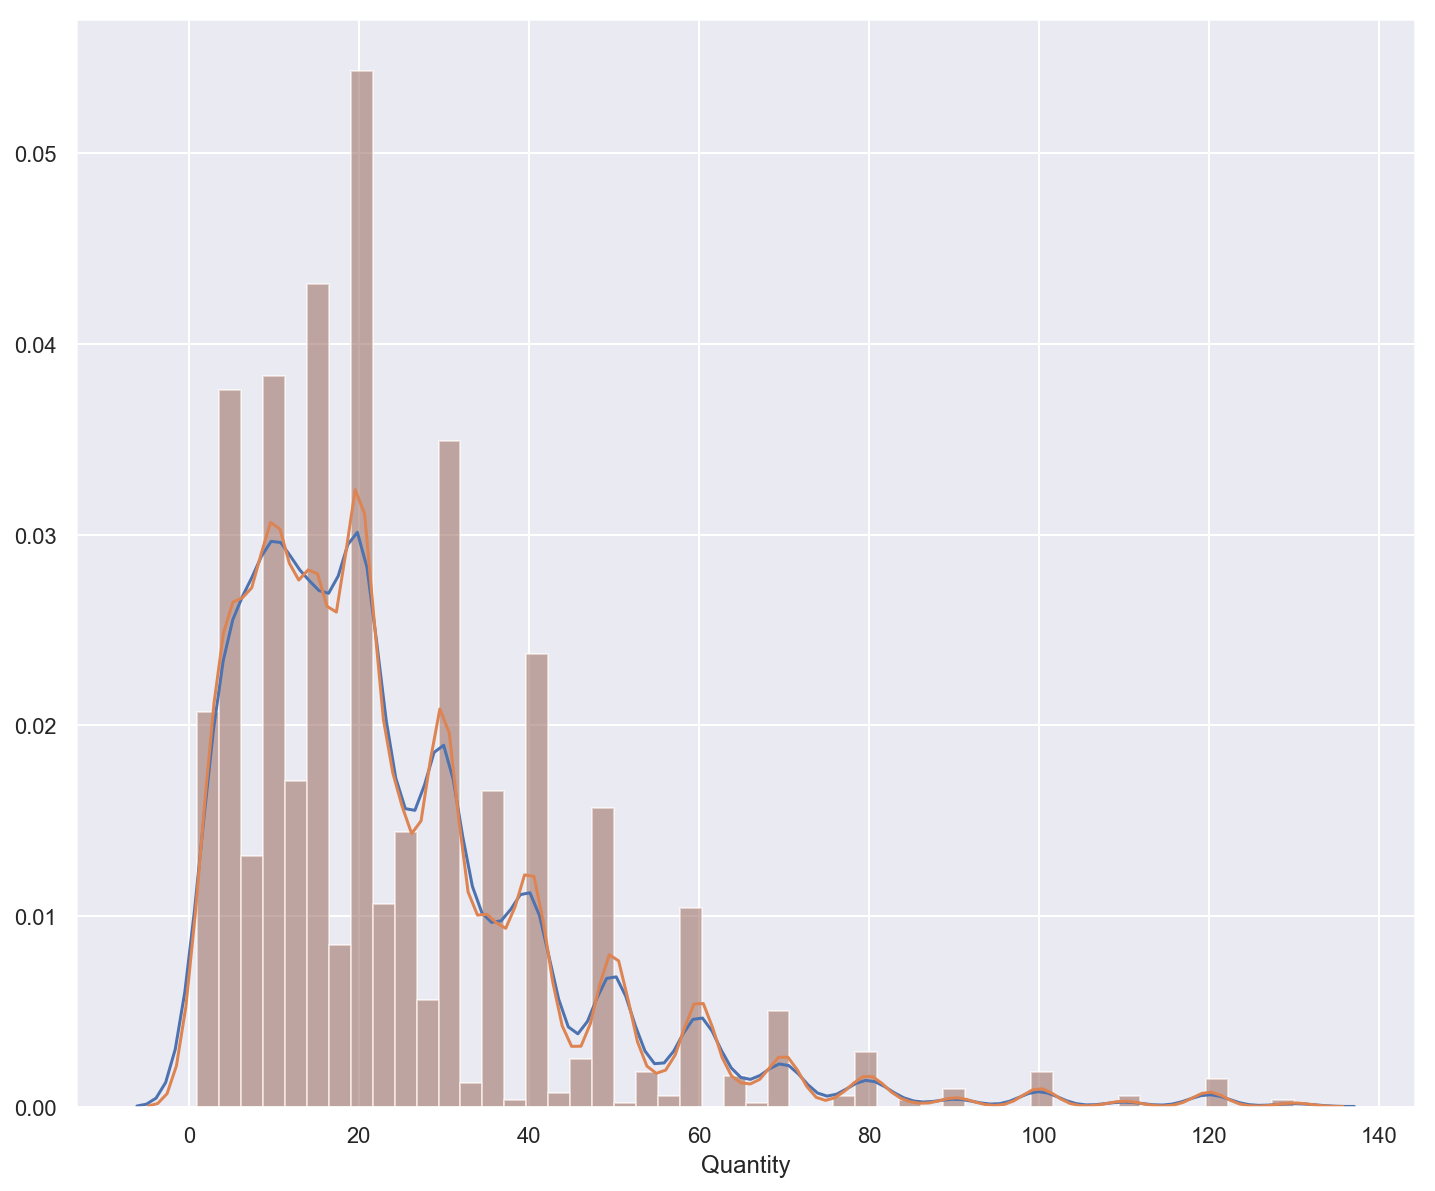

In [33]:
# Plot data and run normality test
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(control) # Blue distribution
sns.distplot(experimental) # Orange distribution

In [35]:
# Create function to sample with replacement
def get_sample(df3, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(df3)
        sample.append(x)
    return sample

# Create function to calculate mean of the sample
def get_sample_mean(sample):
    return sum(sample)/len(sample)

# Combine functions to create a sample distribution
# Create a distribution size of 1000 and sample size of 500
def create_sample_distribution(df3, dist_size=1000, n=500):
    sample_dist = [] 
    while len(sample_dist) != dist_size:
        sample = get_sample(df3, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
    return sample_dist

# Create sample distributions of sample mean for control and target
control_sample = create_sample_distribution(control)
exp_sample = create_sample_distribution(experimental)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


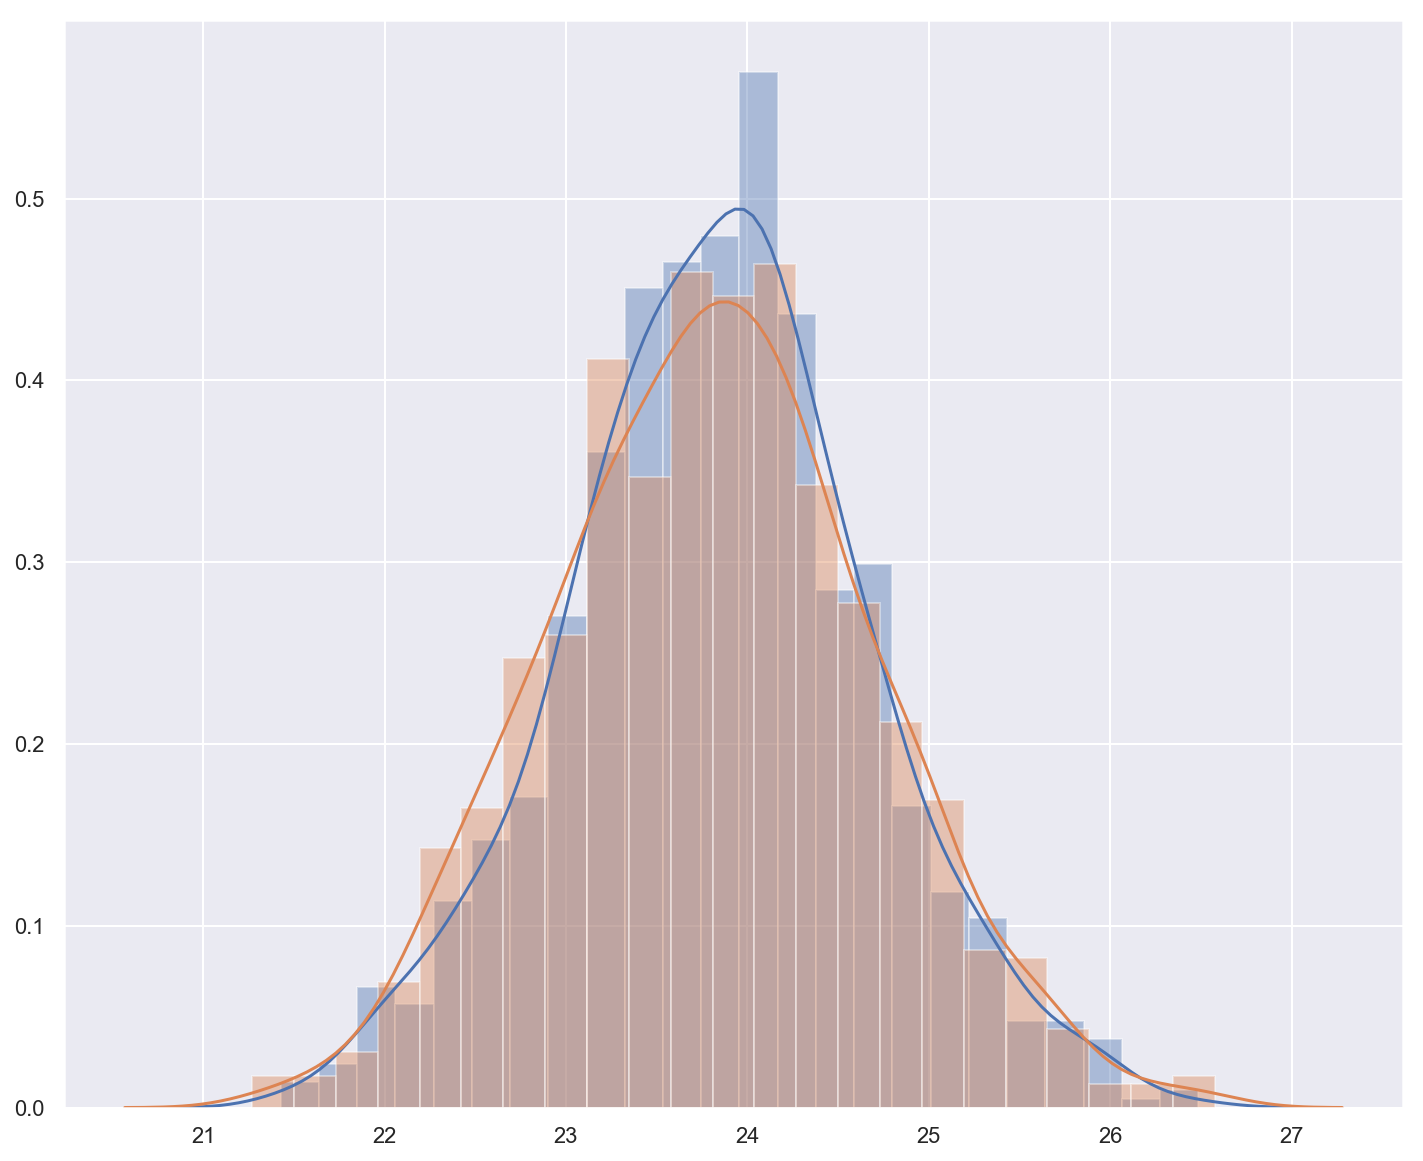

In [36]:
# Plot sample Distribution
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(control_sample) # Blue distribution
sns.distplot(exp_sample) # Orange distribution

In [37]:
# Test whether variances are equal
np.var(control) == np.var(experimental)

False

In [38]:
# Calculate the p_value
stats.ttest_ind(control, experimental, equal_var=False)

Ttest_indResult(statistic=0.0, pvalue=1.0)

### Perform a one-way ANOVA tests for significant differences between groups.

In [39]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'Quantity ~ C(Region)'
lm = ols(formula, df3).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                 sum_sq       df             F  PR(>F)
C(Region)  1.933943e-21      6.0  8.911089e-25     1.0
Residual   2.260259e+07  62488.0           NaN     NaN


The result **p (1.0) > α**, so we fail to reject the null hypothesis. The amount of Chai sold is different between the supplier sources of North America vs Europe.

## Question 4: Do customers in North America purchase the same quantity as other regions?

    Ho: The mean quantity of products ordered by customers in North America is the same as other regions.

    Ha: The mean quantity of products ordered by customers in North America is different regionally.

In [40]:
# Extract Order Detail data as a pandas dataframe using a SQL query
df4 = pd.read_sql_query('''
 SELECT c.Region, od.OrderId, od.Quantity, o.OrderDate
 FROM "Order" o
 JOIN Customer c ON c.Id = o.CustomerId
 JOIN OrderDetail od ON od.OrderId = o.Id
 ''', engine)

2019-05-17 13:39:09,666 INFO sqlalchemy.engine.base.Engine 
 SELECT c.Region, od.OrderId, od.Quantity, o.OrderDate
 FROM "Order" o
 JOIN Customer c ON c.Id = o.CustomerId
 JOIN OrderDetail od ON od.OrderId = o.Id
 
2019-05-17 13:39:09,667 INFO sqlalchemy.engine.base.Engine ()


In [41]:
# Show dataframe
df4.head()

,Region,OrderId,Quantity,OrderDate
0,Western Europe,10248,12,2012-07-04
1,Western Europe,10248,10,2012-07-04
2,Western Europe,10248,5,2012-07-04
3,Western Europe,10249,9,2012-07-05
4,Western Europe,10249,40,2012-07-05


In [42]:
#Convert OrderDate from ojbject to int
df4['OrderDate'] = df4['OrderDate'].astype('datetime64[ns]')

#Pull out month and year from OrderDate
df4['Month'] = df4['OrderDate'].dt.month
df4['Year'] = df4['OrderDate'].dt.year

# Filter orders from 2012 and 2014 and leave only 2013
df4.drop(df4[ (df4['Year'] == 2012) | (df4['Year'] == 2014) ].index, inplace=True)

In [43]:
#Show dataframe
df4.head()

,Region,OrderId,Quantity,OrderDate,Month,Year
398,British Isles,10400,21,2013-01-01,1,2013
399,British Isles,10400,35,2013-01-01,1,2013
400,British Isles,10400,30,2013-01-01,1,2013
401,North America,10401,18,2013-01-01,1,2013
402,North America,10401,70,2013-01-01,1,2013


In [44]:
# Group data by region and show mean
df4.groupby('Region').Quantity.mean()

Region
British Isles      20.495050
Central America    12.800000
Eastern Europe      9.833333
North America      27.643192
Northern Europe    23.175676
Scandinavia        16.447368
South America      21.605634
Southern Europe    15.894737
Western Europe     27.619835
Name: Quantity, dtype: float64

In [45]:
df4 = df4.groupby(['Region', 'Month'])['Quantity'].mean().reset_index()

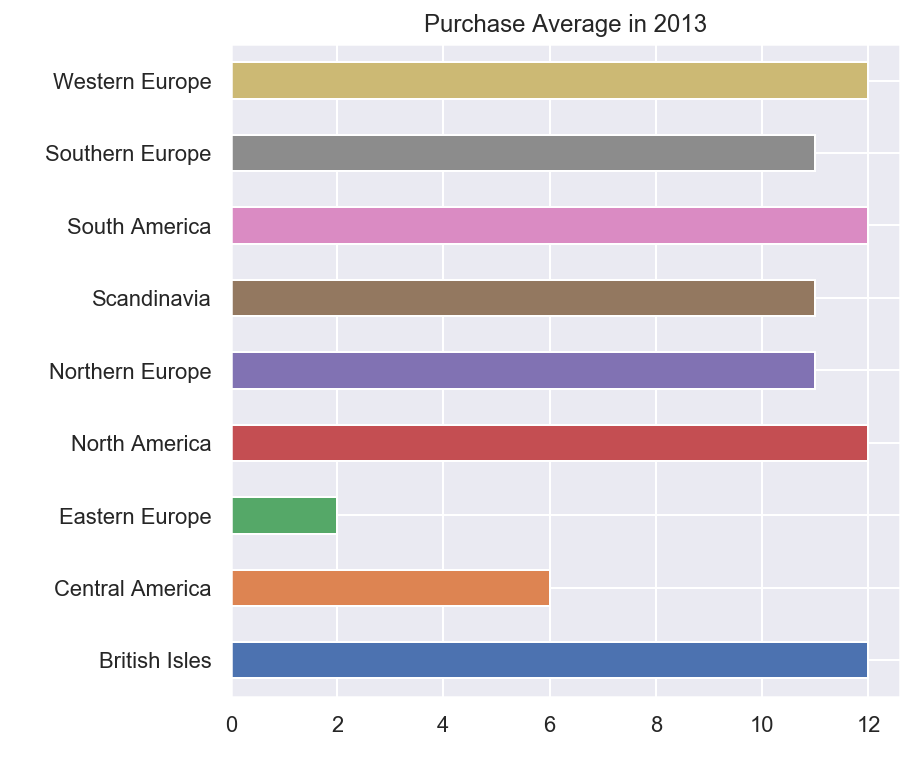

In [46]:
# Plot the number of orders, total revenue per order and average revenue per order for each region
fig, (ax1) = plt.subplots(1, 1, figsize=(6,6))
df4.groupby(['Region'])['Month'].count().plot(kind='barh', ax=ax1)
ax1.set_title('Purchase Average in 2013')
ax1.set_ylabel(' ')
ax1.set_xlabel(' ')
fig.subplots_adjust(hspace=0.1);

In [47]:
# Create control group: Price per order in North America
control = df4[df4['Region'] == 'North America']
control = control['Quantity']

# Create experimental group: Price per order everywhere else
experimental = df4[df4['Region'] != 'North America']
experimental = experimental['Quantity']

In [48]:
# Calculate the difference between distribution means
control.mean()
experimental.mean()
experimental.mean() - control.mean()

-5.648061842206118

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


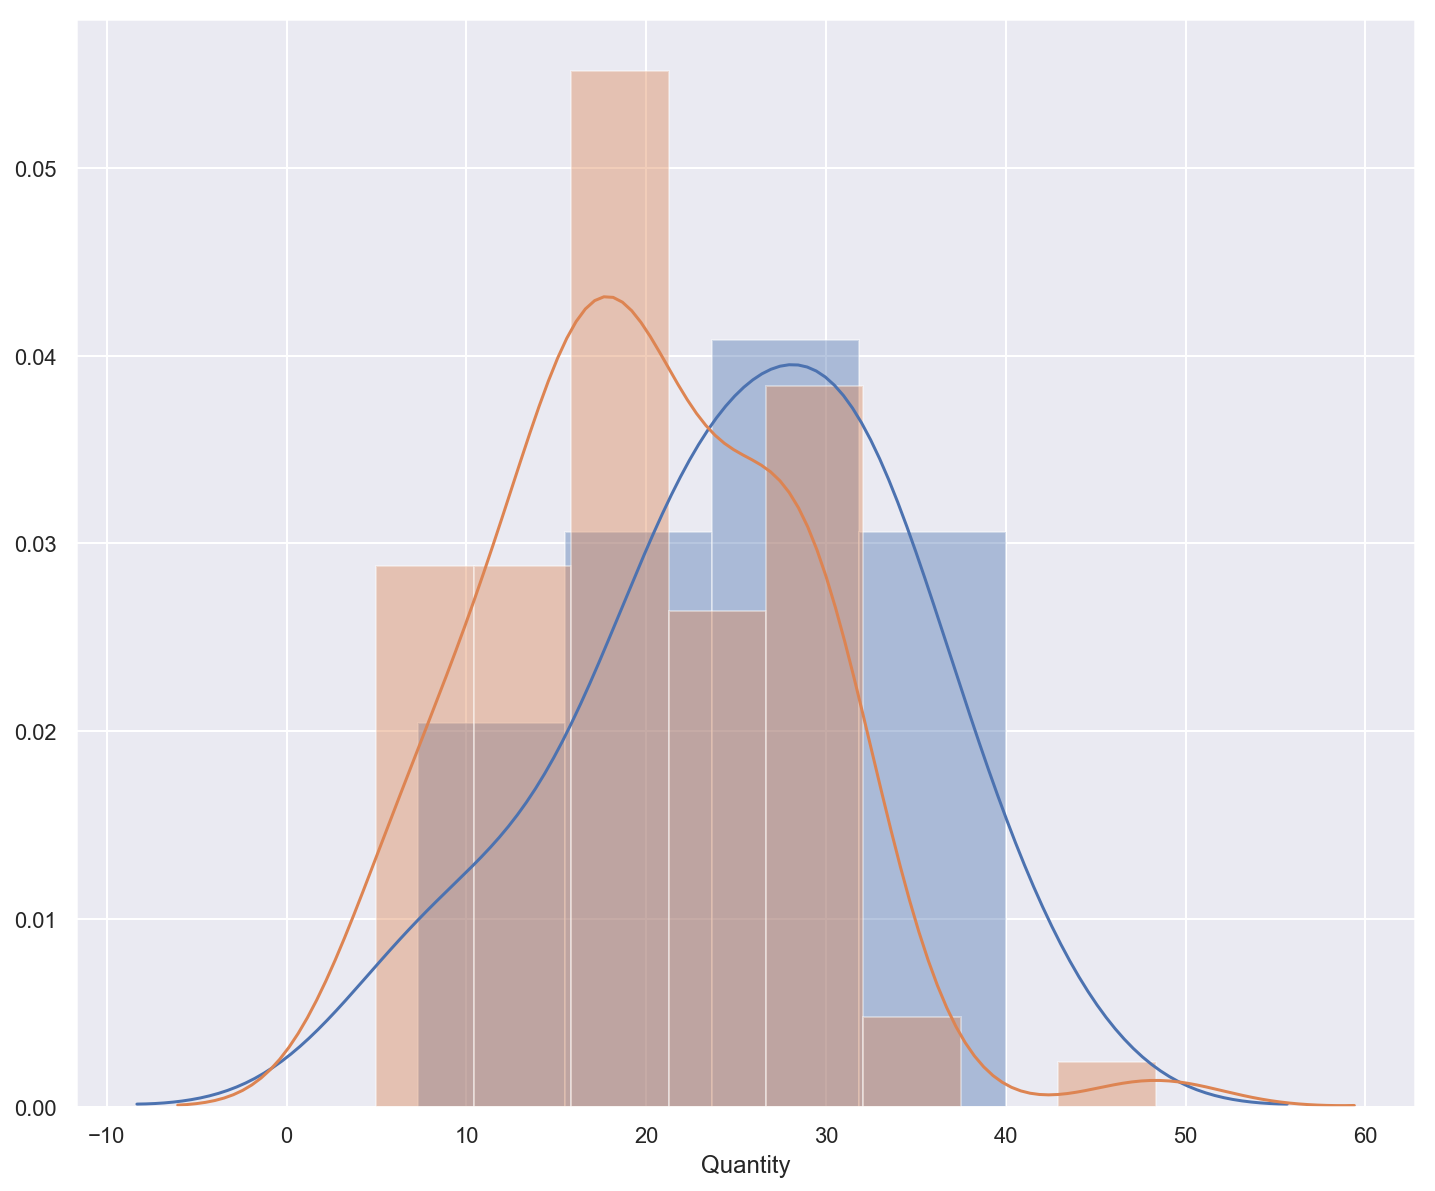

In [49]:
# Plot data and run normality test
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(control) # Blue distribution
sns.distplot(experimental) # Orange distribution

In [50]:
# Create function to sample with replacement
def get_sample(df4, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(df4)
        sample.append(x)
    return sample

# Create function to calculate mean of the sample
def get_sample_mean(sample):
    return sum(sample)/len(sample)

# Combine functions to create a sample distribution
# Create a distribution size of 1000 and sample size of 500
def create_sample_distribution(df4, dist_size=1000, n=500):
    sample_dist = [] 
    while len(sample_dist) != dist_size:
        sample = get_sample(df4, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
    return sample_dist

# Create sample distributions of sample mean for control and target
control_sample = create_sample_distribution(control)
exp_sample = create_sample_distribution(experimental)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


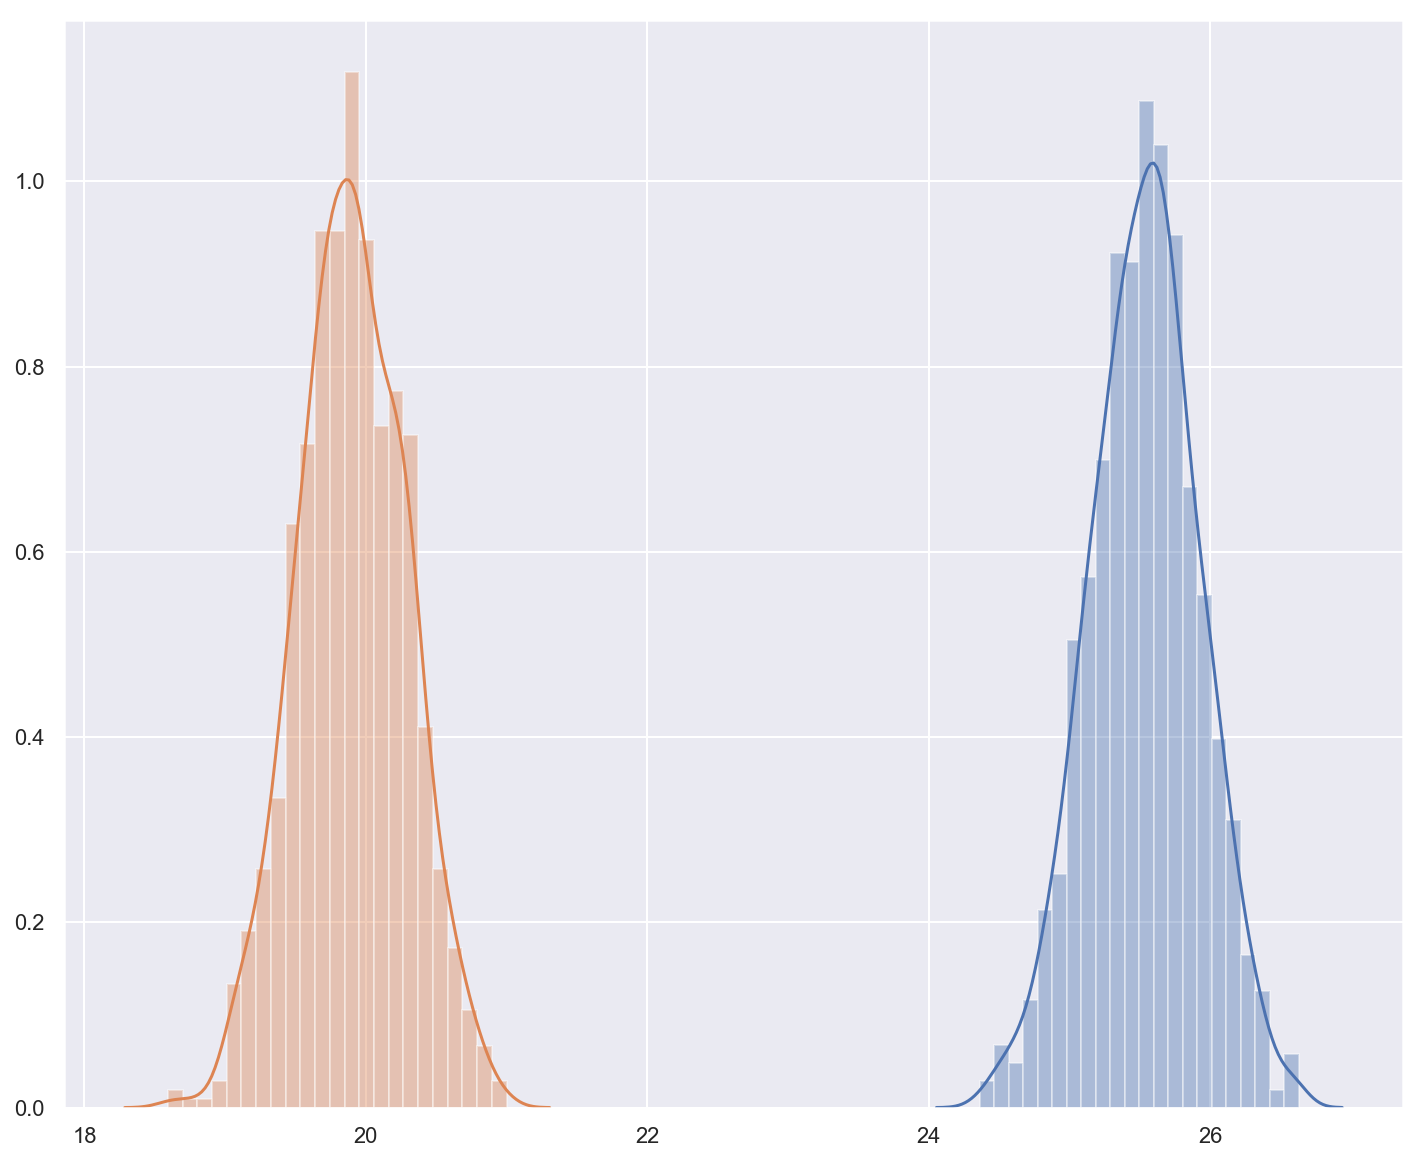

In [51]:
# Plot sample Distribution
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(control_sample) # Blue distribution
sns.distplot(exp_sample) # Orange distribution

In [52]:
# Test whether variances are equal
np.var(control) == np.var(experimental)

False

### Perform a one-way ANOVA test

In [53]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'Quantity ~ C(Region)'
lm = ols(formula, df4).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                sum_sq    df         F    PR(>F)
C(Region)  2543.352758   8.0  6.465086  0.000002
Residual   3933.981035  80.0       NaN       NaN


The result **p (.000002) < α**, so we reject the null hypothesis.